In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_returns(outcomes, num_periods):
    return np.random.choice(outcomes, num_periods)

def sharpe_ratio(returns, num_periods=250, risk_free=0):
    sharpe = (np.mean(returns) - risk_free) / np.std(returns) * np.sqrt(num_periods)
    return sharpe

def ulcer_index(equity_curve):
    _drawdown = drawdown(equity_curve)
    ulcer_index = np.sqrt(np.mean(_drawdown**2)) * 100
    return ulcer_index

# Background
The secret of becoming wealthy through speculation lies in the magic of compounding interest. 

# Coin Flips
Let's start with an illustrative example. I am a wealthy (and extremely generous) casino owner and I've offered you the following opportunity: I'm going to flip a coin, and let you gamble on the results. If it comes up heads, I'll double whatever you bet; tails, you lose your whole wager. It should be immediately obvious this is a game you want to play. The question, then, is how much of your net worth should you put at stake? Intuitively, it should be less than 100%.. you're broke after the first bad flip!

There are two ways to evaluate the expected value: arithmetic and geometric. We'll examine the differences between the two below. If any outcome would cause us to lose more than our entire net worth, we'll bound the set of outcomes such that 

In [3]:
def expected_arith(returns):
    expected_arith = np.mean(returns)
    return expected_arith

def expected_geom(returns):
    returns = np.array(returns)
    expected_geom = np.product(1 + returns) ** (1 / len(returns)) - 1
    return expected_geom

In [4]:
coin_outcomes = np.array([2, -1])
coin_exp_arith = expected_arith(coin_outcomes)
coin_exp_geom = expected_geom(coin_outcomes) 
print('Expected Value (Arithmetic): {}%'.format(coin_exp_arith * 100))
print('Expected Value (Geometric): {}%'.format(coin_exp_geom * 100))

Expected Value (Arithmetic): 50.0%
Expected Value (Geometric): -100.0%


In the scenario where you wager everything you've got, there is a radical difference in expected value! While on average, you think you'd make $0.50 for every dollar wagered, the real result is that you're likely to lose everything. Let's see what happens if we only bet 5% of our total stake.

In [5]:
fractional_coin_outcomes = 0.01 * coin_outcomes
coin_exp_arith_fr = expected_arith(fractional_coin_outcomes)
coin_exp_geom_fr = expected_geom(fractional_coin_outcomes)
print('Expected Value (Arithmetic): {}%'.format(np.round(coin_exp_arith_fr * 100, 3)))
print('Expected Value (Geometric): {}%'.format(np.round(coin_exp_geom_fr * 100, 3)))

Expected Value (Arithmetic): 0.5%
Expected Value (Geometric): 0.489%


## Kelly Criterion

In this scenario, the expected outcomes are much closer to one another! The geometric expectancy is slightly lower than the arithmetic counterpart (this is actually always the case).

For simple scenarios such as this, there is actually a simple formula to determine the optimal fraction of your bankroll/ account to stake. Known as the Kelly Criterion, the formula is defined as follows:

<center>Kelly %  = $W - \frac{1 - W}{R}$</center>

Where <br />
W = the probability of winning a given bet <br />
R = the ratio of a winning bet to a losing bet

In [6]:
def worst_loss(returns):
    return np.abs(np.min(returns))

def bound_returns(returns):
    return returns / worst_loss(returns)

In [7]:
def kelly_fraction(returns):
    returns = np.array(returns)
    wins = returns[returns > 0]
    losses = returns[returns <= 0]
    W = len(wins) / len(returns)
    R = np.mean(wins) / np.abs(np.mean(losses))
    kelly_f = W - ( (1 - W) / R )
    return kelly_f

def kelly_results(returns):
    bounded_rets = bound_returns(returns)
    kelly_f = kelly_fraction(bounded_rets) / worst_loss(returns)

    exp_arith_kelly = expected_arith(returns * kelly_f)
    exp_geom_kelly = expected_geom(bounded_rets * kelly_f)

    print('Kelly f: {}'.format(np.round(kelly_f, 3)))
    print('Expected Value (Arithmetic): {}%'.format(np.round(exp_arith_kelly * 100, 5)))
    print('Expected Value (Geometric): {}%'.format(np.round(exp_geom_kelly * 100, 5)))

Let's see the optimal fraction to stake based on the Kelly Criterion

In [8]:
kelly_results(coin_outcomes)

Kelly f: 0.25
Expected Value (Arithmetic): 12.5%
Expected Value (Geometric): 6.06602%


## Optimal f

Alternatively, we can see if there's a sweet spot for stake percentage by iterating through all possible fractions and evaulating the expected geometric returns at each. This will generate a curve, and the peak of this curve represents the optimal fraction to bet. Ralph Vince has termed this point "optimal f". We'll consider all values which don't cause us to go bust. To do so, we'll divide the stake percentage by our worst loss. The most we would ever wager is an amount such that the worst possible outcome would cause us to lose all of our money.

In [9]:
def get_f(returns):
    exp_df = pd.DataFrame(columns=['arithmetic', 'geometric'])
    f_values = np.linspace(0, 1, 101)    
    max_loss = worst_loss(returns)
    bounded_f = f_values / max_loss
    for f in bounded_f:
        exp_df.loc[f, 'arithmetic'] = expected_arith(f * returns)
        exp_df.loc[f, 'geometric'] = expected_geom(f * returns)
    optimal_f = exp_df['geometric'].idxmax()
    return {'f_curve':exp_df, 'optimal_f':optimal_f, 'max_loss':max_loss}

def f_plots2(f, title=''):
    f_curve = f['f_curve']
    optimal_f = f['optimal_f']
    max_loss = f['max_loss']
    f_exp = f_curve.loc[optimal_f, 'geometric']
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 15), sharex=False)
    f_curve.plot(ax=ax[0])
    ax[0].plot(optimal_f, f_curve.loc[optimal_f, 'geometric'], color='r', marker='x')
    ax[0].axhline(0, color='k')
    # ax[0].set_xticks(np.linspace(0, x_lim, 11))
    ax[0].set_xlabel('Fraction Staked')
    ax[0].set_ylabel('Expected Return %')
    ax[0].set_title(title + ' Optimal f')

    # There's probably a better way to do this, but I'm no matplotlib guru
    f_curve.plot(ax=ax[1])
    ax[1].plot(optimal_f, f_curve.loc[optimal_f, 'geometric'], color='r', marker='x')
    ax[1].axhline(0, color='k')
    ax[1].axvline(optimal_f, color='r', linestyle=':')
    ax[1].axhline(f_curve.loc[optimal_f, 'geometric'], color='r', linestyle=':')
    ax[1].set_xlim(0, optimal_f * 2.25)
    ax[1].set_ylim(-f_exp, f_exp * 1.25)
    # ax[1].set_xticks(np.linspace(0, x_lim / 2, 11))
    ax[1].set_xlabel('Fraction Staked')
    ax[1].set_ylabel('Expected Return %')
    ax[1].set_title(title + ' Optimal f')

    plt.savefig(title + ' optimal f.png', bbox_inches='tight')
    plt.show()
    
def f_plots(f, title=''):
    f_curve = f['f_curve']
    optimal_f = f['optimal_f']
    max_loss = f['max_loss']
    f_exp = f_curve.loc[optimal_f, 'geometric']
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=False)
    f_curve.plot(ax=ax)
    ax.plot(optimal_f, f_curve.loc[optimal_f, 'geometric'], color='r', marker='x')
    ax.axhline(0, color='k')
    ax.axvline(optimal_f, color='r', linestyle=':')
    ax.axhline(f_curve.loc[optimal_f, 'geometric'], color='r', linestyle=':')
    ax.set_xlim(0, optimal_f * 2.25)
    ax.set_ylim(-f_exp, f_exp * 1.25)
    ax.set_xlabel('Fraction Staked')
    ax.set_ylabel('Expected Return %')
    ax.set_title(title + ' Optimal f')

    plt.savefig(title + ' optimal f.png', bbox_inches='tight')
    plt.show()
    
def f_results(f):
    f_curve = f['f_curve']
    optimal_f = f['optimal_f']
    exp_arith = f_curve.loc[optimal_f, 'arithmetic']
    exp_geom = f_curve.loc[optimal_f, 'geometric']
    
    print('Optimal f: {}'.format(np.round(optimal_f, 3)))
    print('Expected Value (Arithmetic): {}%'.format(np.round(exp_arith, 5) * 100))
    print('Expected Value (Geometric): {}%'.format(np.round(exp_geom, 5) * 100))

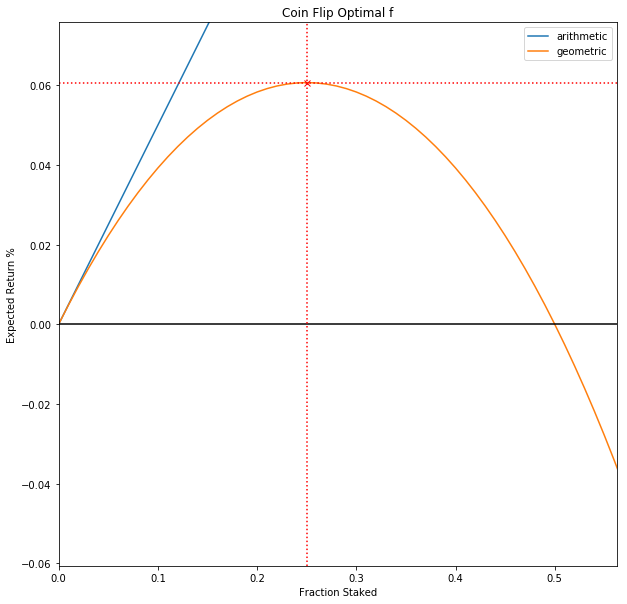

Optimal f: 0.25
Expected Value (Arithmetic): 12.5%
Expected Value (Geometric): 6.066%


In [10]:
coin_f = get_f(coin_outcomes)
f_plots(coin_f, title='Coin Flip')
f_results(coin_f)

As we can see, this approach returns the same results as the Kelly formula. We'll soon discover this approach offers some benefits to plugging values into the formula. It's also important to notice from the graph the implications of risking too much of your capital. Even though this game has an extremely high expected payout (almost surely higher than any you're likely to find in real life!), risking more than 50% of your total bankroll on each bet will cause the expected compound growth of your capital to be negative. In fact, staking more than the optimal f fraction of your account will actually have a negative impact on compounded growth. It should be clear that the idea of "betting big to win big" does not always hold. 

# Dice

Let's step things up a notch here. The next scenario we'll consider is a dice roll. I'm still the same altruistic rich guy, and I've offered you the opportunity to bet on the roll of a six-sided die. If an even number comes up, I'll pay you that multiple of your bet. If it comes up odd, you pay me that multiple. Again, we see that the arithmetic expectancy of this game is in your favor. However, in order to assess the geometric average return of this game, we'll first need to bound the returns. Since you'll pay me five times your wager if you roll a five, the most you could possibly bet is 1/5 of your capital.

In [11]:
dice_outcomes = np.array([-1, 2, -3, 4, -5, 6])

dice_outcomes_bounded = bound_returns(dice_outcomes)
dice_exp_arith = expected_arith(dice_outcomes_bounded) * 100
dice_exp_geom = expected_geom(dice_outcomes_bounded) * 100

print('Expected Value (Arithmetic): {}%'.format(np.round(dice_exp_arith), 3))
print('Expected Value (Geometric): {}%'.format(np.round(dice_exp_geom), 3))

Expected Value (Arithmetic): 10.0%
Expected Value (Geometric): -100.0%


Again, we see that what looks like a great bet at the onset will eventually leave you dead broke if your risk too much. We can use the Kelly Criterion to try and determine what the optimal amount to stake on each roll is.

In [12]:
kelly_results(dice_outcomes)

Kelly f: 0.025
Expected Value (Arithmetic): 1.25%
Expected Value (Geometric): 0.2314%


And let's compare that to the optimal f value by evaluating the peak of the curve.

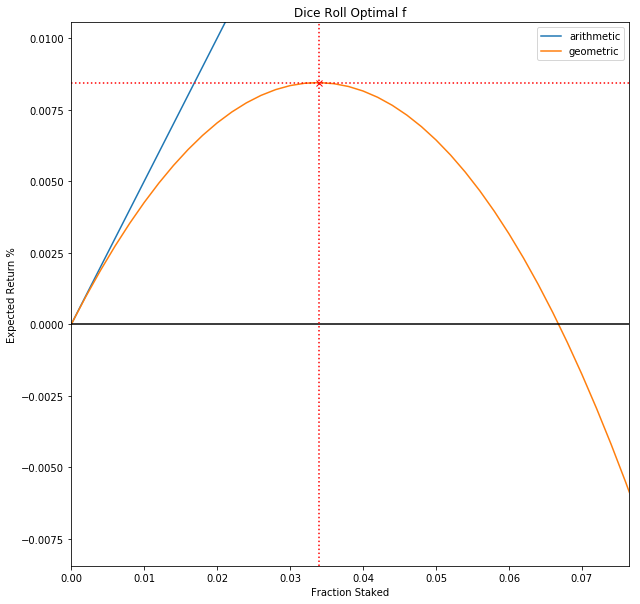

Optimal f: 0.034
Expected Value (Arithmetic): 1.7000000000000002%
Expected Value (Geometric): 0.844%


In [13]:
dice_f = get_f(dice_outcomes)
f_plots(dice_f, title='Dice Roll')
f_results(dice_f)

In the scenario where possible outcomes are not binary, the Kelly Criterion doesn't return the optimal solution. You'd be leaving money on the table calculating your bet size this way!

# Market Returns

Finally, we'll get to a real application. No casino can stay in business offering games that give gamblers an edge over the house (if you find one, let me know!). However, the stock market has proved to be a reliable way to grow one's capital through compounding historically. Let's find out how much capital we should devote to the market in order to get the maximum returns!

It's worth mentioning at this point that the approaches used going forward are only valid if future market returns match past returns. As any financial advisor worth their salt will tell you, this **IS NOT GUARANTEED**. Unlike the games covered previously, where all possible outcomes were defined in advance, the markets offer no guarantees. The best we can do is plug in past returns and make tweaks if we deem them necessary.

For this study, we'll use the daily returns of the 'SPY' S&P 500 ETF as our outcomes.

In [14]:
# SPY.csv file available in GitHub 'data' folder
spy = pd.read_csv('SPY.csv', parse_dates=True, index_col=0)
spy.sort_index(ascending=True, inplace=True)
spy.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.9687,43.9687,43.7500,43.9375,27.357281,1003200
1993-02-01,43.9687,44.2500,43.9687,44.2500,27.551851,480500
1993-02-02,44.2187,44.3750,44.1250,44.3437,27.610189,201300
1993-02-03,44.4062,44.8437,44.3750,44.8125,27.902090,529400
1993-02-04,44.9687,45.0937,44.4687,45.0000,28.018848,531500


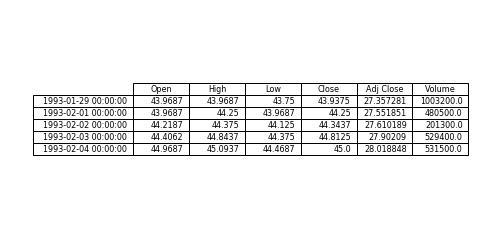

In [15]:
from pandas.plotting import table
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, spy.head(), loc='center')

In [16]:
# Use daily returns from adjusted closing prices
spy_returns = spy['Adj Close'].pct_change().dropna()
spy_returns.describe()

count    6357.000000
mean        0.000425
std         0.011575
min        -0.098448
25%        -0.004382
50%         0.000669
75%         0.005787
max         0.145198
Name: Adj Close, dtype: float64

In [17]:
kelly_results(spy_returns)

Kelly f: 0.568
Expected Value (Arithmetic): 0.02413%
Expected Value (Geometric): 0.01722%


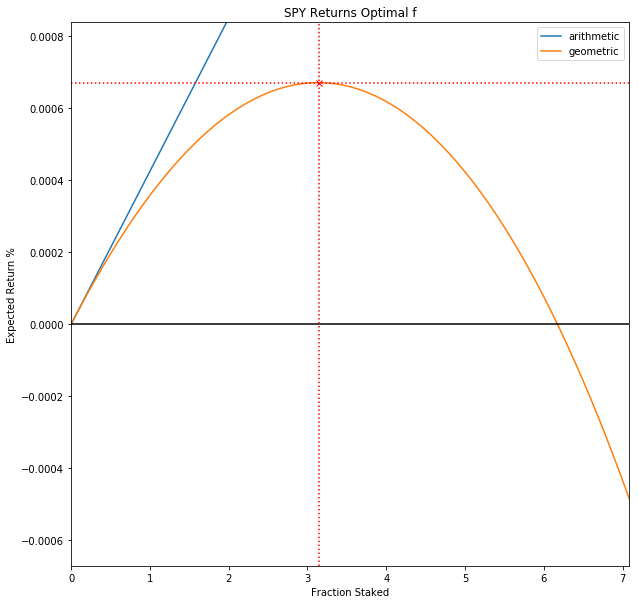

Optimal f: 3.149
Expected Value (Arithmetic): 0.134%
Expected Value (Geometric): 0.067%


In [18]:
spy_f = get_f(spy_returns)
f_plots(spy_f, title='SPY Returns')
f_results(spy_f)

In [19]:
expected_geom(3.14 * spy_returns)

0.00067118697633405944

In this case, we should actually bet *more* capital than we have. To do so, we'll have to employ leverage; either by borrowing money to increase the bet size or by trading instruments with inherent leverage such as options or futures.

# Drawdown

To this point, we've solely focused on maximizing the return on our capital. However, as an investor we're likely just as concerned with how much risk we're taking on. We'll see below that the path taken to reach the maximum final account value is certainly not an easy one. From peak equity, an investor would need to weather a 97% drawdown on the path to the greatest final account value. It's unlikely that anyone could stick with this strategy.

In [20]:
def equity_curve(returns):
    _equity_curve = (1 + returns).cumprod(axis=0)
    # Set the starting value of every curve to 1
    # normalized_eq = raw_eq / raw_eq[0]
    return _equity_curve

def drawdown(equity_curve):
    eq_series = pd.DataFrame(equity_curve)
    _drawdown = eq_series / eq_series.cummax() - 1
    return _drawdown

def max_drawdown(equity_curve, percent=True):
    abs_drawdown = np.abs(drawdown(equity_curve)).values
    _max_drawdown = np.max(abs_drawdown)
    if percent == True:
        return _max_drawdown * 100
    else:
        return _max_drawdown
    
def ulcer_index(equity_curve):
    _drawdown = drawdown(equity_curve)
    _ulcer_index = np.sqrt(np.mean(_drawdown**2)) * 100
    return _ulcer_index

def equity_plot(returns, title=''):
    fig, ax = plt.subplots(2, 1, figsize = (10, 10), sharex=True)
    eq = equity_curve(returns)
    dd = drawdown(eq) * 100
    ax[0].plot(eq)
    ax[0].set_title('Equity (Multiple of Starting Value)')
    dd.plot(ax=ax[1], kind='area')
    ax[1].set_title('Drawdown (%)')
    plt.savefig(title + ' Equity Plot.png')
    plt.show()

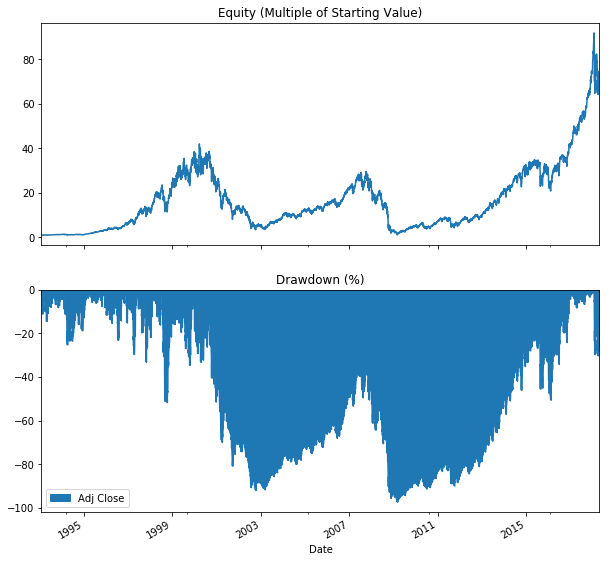

Max Drawdown: 97.23%


In [22]:
optimal_returns = spy_returns * spy_f['optimal_f']
equity_plot(optimal_returns, title='SPY Optimal f')
max_dd = max_drawdown(equity_curve(optimal_returns))
print("Max Drawdown: {}%".format(np.round(max_dd, 2)))

In [23]:
def twr(equity_curve, start_at_1=True):
    eq_arr = np.array(equity_curve)
    if start_at_1 == True:
        _twr = eq_arr[-1] 
    else:
        _twr = eq_arr[-1] / eq_arr[0]
    return _twr

def ghpr(equity_curve):
    _twr = twr(equity_curve)
    _ghpr = _twr ** (1 / len(equity_curve)) - 1
    return _ghpr

In [24]:
def get_f_dd(returns):
    f_values = np.linspace(0, 0.99, 100)
    max_loss = np.abs(np.min(returns))
    bounded_f = f_values / max_loss
    df = pd.DataFrame(columns=['ghpr', 'drawdown'])    
    for f in bounded_f:
        eq = equity_curve(f * returns)
        _ghpr = ghpr(eq)
        _max_drawdown = max_drawdown(eq)
        # _ulcer_index = ulcer_index(eq)
        df.loc[f, 'ghpr'] = _ghpr * 100
        df.loc[f, 'drawdown'] = _max_drawdown
        # df.loc[f, 'ulcer index'] = _ulcer_index
    optimal_f = df['ghpr'].idxmax()
    return {'f_curve':df, 'optimal_f':optimal_f, 'max_loss':max_loss}

def f_dd_plot(f, title=''):
    f_curve = f['f_curve']
    optimal_f = f['optimal_f']
    optimal_f_ghpr = f_curve.loc[optimal_f, 'ghpr']
    limit_dd = f_curve.loc[2 * optimal_f, 'drawdown']

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    f_curve.plot(secondary_y='drawdown', ax=ax)

    ax.set_xlim(0, optimal_f * 2)
    ax.set_ylim(0, 1.5 * optimal_f_ghpr)
    ax.right_ax.set_ylim(0)
    ax.set_title(title + ' GHPR vs Max Drawdown')
    ax.set_xlabel('Fraction Staked')
    ax.set_ylabel('GHPR (%)')
    ax.right_ax.set_ylabel('Drawdown (%)')
    ax.axvline(optimal_f, linestyle=':', color='red')
    
    plt.savefig(title + ' f Drawdown Curve.png')   
    plt.show()
    
def f_dd_results(f):
    f_curve = f['f_curve']
    optimal_f = f['optimal_f']
    ghpr = f_curve.loc[optimal_f, 'ghpr']
    drawdown = f_curve.loc[optimal_f, 'drawdown']
    
    print('Optimal f: {}'.format(np.round(optimal_f, 3)))
    print('Geometric Holding Period Return: {}%'.format(np.round(ghpr, 5)))
    print('Max Drawdown: {}%'.format(np.round(drawdown, 2)))

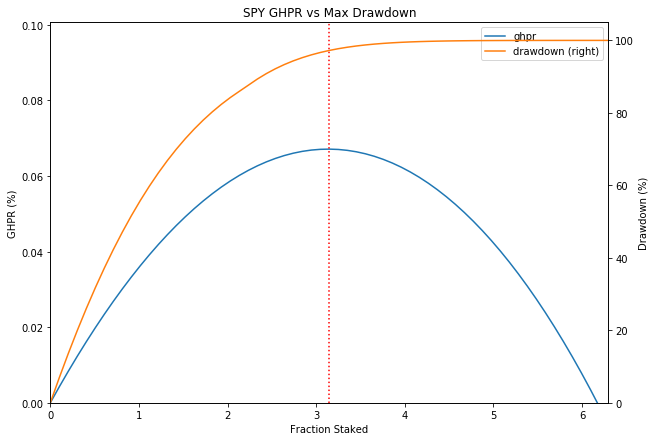

Optimal f: 3.149
Geometric Holding Period Return: 0.06712%
Max Drawdown: 97.23%


In [25]:
spy_f = get_f_dd(spy_returns)
    
f_dd_plot(spy_f, 'SPY')    
f_dd_results(spy_f)

In [26]:
def get_f_bounded(returns, drawdown_limit):
    f_values = np.linspace(0, 0.99, 199)
    max_loss = np.abs(np.min(returns))
    bounded_f = f_values / max_loss
    df = pd.DataFrame(columns=['ghpr', 'drawdown'])    
    for f in bounded_f:
        eq = equity_curve(f * returns)
        _max_drawdown = max_drawdown(eq)
        if _max_drawdown <= drawdown_limit:
            _ghpr = ghpr(eq)
        else:
            _ghpr = 0
        df.loc[f, 'ghpr'] = _ghpr * 100
        df.loc[f, 'drawdown'] = _max_drawdown
    optimal_f = df['ghpr'].idxmax()
    return {'f_curve':df, 'optimal_f':optimal_f, 'max_loss':max_loss}

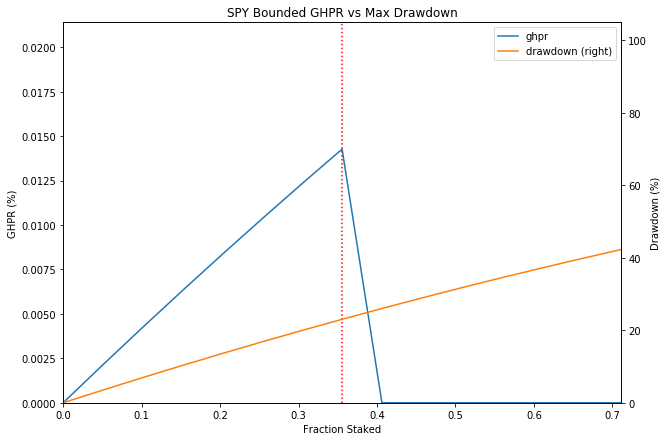

Optimal f: 0.356
Geometric Holding Period Return: 0.01427%
Max Drawdown: 23.04%


In [27]:
spy_f_bounded = get_f_bounded(spy_returns, drawdown_limit=25)
f_dd_plot(spy_f_bounded, 'SPY Bounded')
f_dd_results(spy_f_bounded)

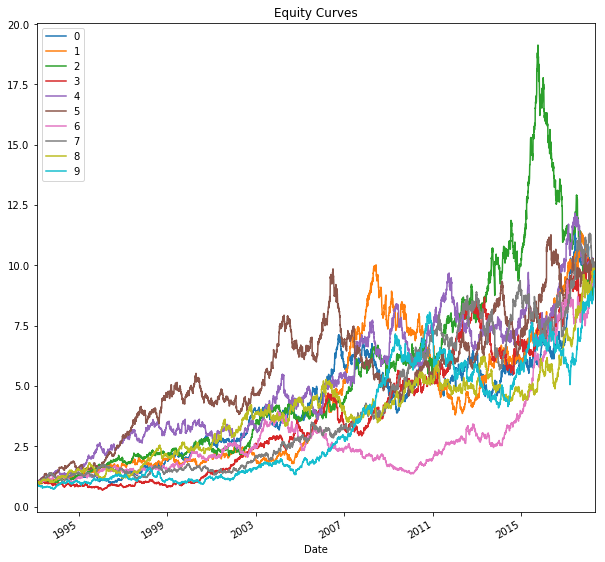

In [28]:
def reordered_curves(returns, n_curves):
    curves = pd.DataFrame(index=returns.index)
    for i in range(n_curves):
        reordered = np.random.permutation(returns)
        curves[i] = equity_curve(reordered)
    return curves

spy_curves_10 = reordered_curves(spy_returns, 10)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
spy_curves_10.plot(ax=ax)
ax.set_title('Equity Curves')
plt.savefig('10 Equity Curves.png')
plt.show()

In [31]:
curve_results = pd.DataFrame()
curve_results['GHPR'] = ghpr(spy_curves_10)
curve_results['Max Drawdown'] = max_drawdown(spy_curves_10)
curve_results

,GHPR,Max Drawdown
0,0.000358,65.712538
1,0.000358,65.712538
2,0.000358,65.712538
3,0.000358,65.712538
4,0.000358,65.712538
5,0.000358,65.712538
6,0.000358,65.712538
7,0.000358,65.712538
8,0.000358,65.712538
9,0.000358,65.712538


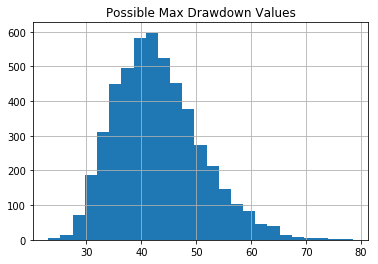

Maximum Drawdown: 78.479%


In [33]:
spy_curves_5000 = reordered_curves(spy_returns, 5000)
spy_drawdown_5000 = spy_curves_5000.apply(max_drawdown)
spy_drawdown_5000.hist(bins=25)
plt.title('Possible Max Drawdown Values')
plt.savefig('5000 SPY Drawdown Values.png')
plt.show()
print('Maximum Drawdown: {}%'.format(np.round(spy_drawdown_5000.max(), 3)))

In [34]:
import time

def ideal_f(returns, time_horizon, n_curves, drawdown_limit, certainty_level):    
    """
    Calculates ideal fraction to stake on an investment with given return distribution 

    Args:
        returns: (array-like) distribution that's representative of future returns
        time_horizon: (integer) the number of returns to sample for each curve
        n_curves: (integer) the number of equity curves to generate on each iteration of f
        drawdown_limit: (real) user-specified value for drawdown which must not be exceeded
        certainty_level: (real) the level of confidence that drawdown
            limit will not be exceeded

    Returns:
        'f_curve': calculated drawdown and ghpr value at each value of f
        'optimal_f': the ideal fraction of one's account to stake on an investment
        'max_loss': the maximum loss sustained in the provided returns distribution

    """
    print('Calculating ideal f...')
    start = time.time()
    
    f_values = np.linspace(0, 0.99, 200)
    max_loss = np.abs(np.min(returns))
    bounded_f = f_values / max_loss
    f_curve = pd.DataFrame(columns=['ghpr', 'drawdown'])    
    for f in bounded_f:
        # Generate n_curves number of random equity curves
        reordered_returns = np.random.choice(f * returns, size=(time_horizon, n_curves))
        curves = equity_curve(reordered_returns)
        curves_df = pd.DataFrame(curves)        
        # Calculate GHPR and Maximum Drawdown for each equity curve
        curves_drawdown = max_drawdown(curves_df)
        curves_ghpr = ghpr(curves_df) 
        # Calculate drawdown at our certainty level
        drawdown_percentile = np.percentile(curves_drawdown, certainty_level)
        # Calculate median ghpr value
        ghpr_median = np.median(curves_ghpr)
        if drawdown_percentile <= drawdown_limit:
            _ghpr = ghpr_median
        else:
            _ghpr = 0
        f_curve.loc[f, 'ghpr'] = _ghpr * 100
        f_curve.loc[f, 'drawdown'] = drawdown_percentile
    optimal_f = f_curve['ghpr'].idxmax()
    
    elapsed = time.time() - start
    print('Ideal f calculated in {}s'.format(elapsed))
    
    return {'f_curve':f_curve, 'optimal_f':optimal_f, 'max_loss':max_loss}

In [35]:
spy_ideal_f = ideal_f(spy_returns, time_horizon=250, n_curves=1000, drawdown_limit=25, certainty_level=95)

Calculating ideal f...
Ideal f calculated in 1.9460525512695312s


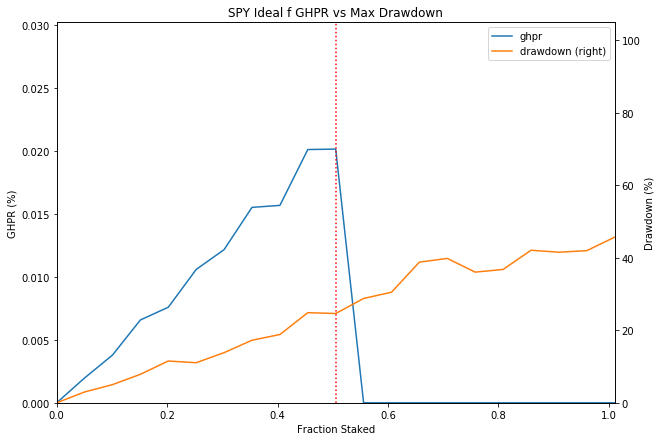

Optimal f: 0.505
Geometric Holding Period Return: 0.02016%
Max Drawdown: 24.64%


In [36]:
f_dd_plot(spy_ideal_f, title='SPY Ideal f')
f_dd_results(spy_ideal_f)